In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
df=pd.read_csv("champagne_sales.csv")
df

,Month,Champagne sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [3]:
df["Month"]=pd.to_datetime(df["Month"])
df

,Month,Champagne sales
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946
...,...,...
100,1972-05-01,4618
101,1972-06-01,5312
102,1972-07-01,4298
103,1972-08-01,1413


In [4]:
df.set_index("Month",inplace=True)
df

,Champagne sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [5]:
train = df.iloc[:int(len(df)*0.9)]
test =df.iloc[int(len(df)*0.9):]

In [6]:
train

,Champagne sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1971-06-01,4874
1971-07-01,4633
1971-08-01,1659


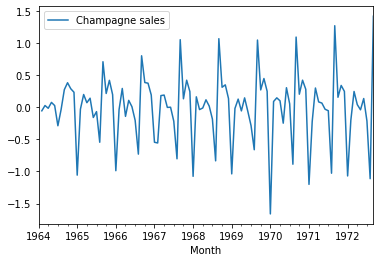

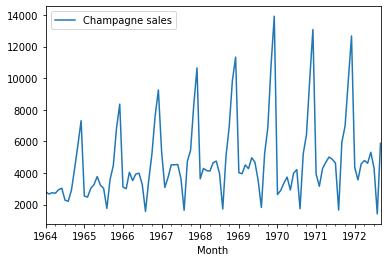

In [7]:
log_returns=np.log(1+df.pct_change())
log_returns.plot()
df.plot()

In [8]:
from seaborn.distributions import histplot
def monte_carlo_sim(data,interval=len(test),iterations=5000):
  log_returns = np.log(1+data.pct_change())
  u =log_returns.mean()
  var = log_returns.var()
  drift = u - (0.5*var)
  stdev = log_returns.std()
  daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(interval,iterations)))
  S0 = data.iloc[-1]
  price_list = np.zeros_like(daily_returns)
  price_list[0] = S0

  for t in range(1,interval):
    price_list[t]=price_list[t-1]*daily_returns[t]
  
  plt.plot(price_list)
  x = pd.DataFrame(price_list).iloc[-1]
  fig,ax = plt.subplots(1,2,figsize=(14,4))
  sns.displot(x,ax=ax[0])
  sns.displot(x,line_kws={"cumulative":True},kde_kws={"cumulative":True},ax=ax[1])
  plt.xlabel("Stock Price")
  plt.show()
  print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


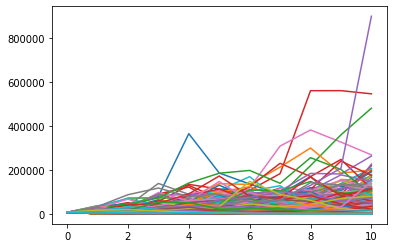

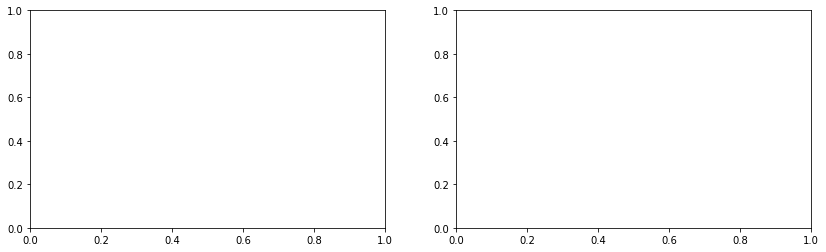

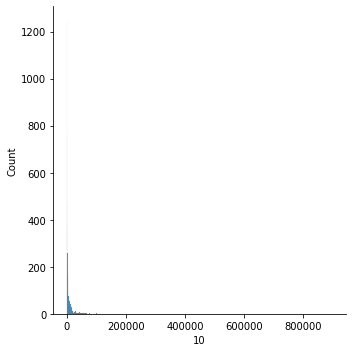

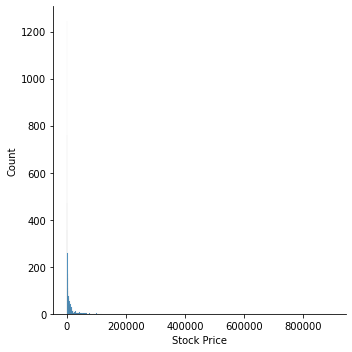

Expected Value: $7427.03


In [9]:
monte_carlo_sim(train)

In [10]:
#ARIMA-SARIMA
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from pmdarima.arima import ADFTest, auto_arima

In [12]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.01, False)

In [13]:
train = df[:85]
test = df[-20:]

In [14]:
arima_model = auto_arima(train,start_p=0,d=1,start_q=0,max_q=5,max_p=5,n_fits=100,m=12,seasonal=True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   85
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 12)   Log Likelihood                -583.282
Date:                             Sun, 01 Jan 2023   AIC                           1174.564
Time:                                     17:53:08   BIC                           1183.670
Sample:                                 01-01-1964   HQIC                          1178.189
                                      - 01-01-1971                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8412      0.152     -5.545      0.000      -1.138      -0.544
ma.L1          0.0513      0.167      0.308      0.758      -0.275       0.378
ma.L2         -0.8673      0.086    -10.139      0.000      -1.035      -0.700
sigma2      5.862e+05   7.03e+04      8.342      0.000    4.48e+05    7.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.55
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               2.61   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
prediction = pd.DataFrame(arima_model.predict(n_periods=20),index=test.index)
prediction.columns=["Predicted_sales"]
prediction

,Predicted_sales
Month,
1971-02-01,2746.586007
1971-03-01,3248.053081
1971-04-01,3592.425511
1971-05-01,2800.982302
1971-06-01,3841.849672
1971-07-01,4088.102048
1971-08-01,1596.272416
1971-09-01,5090.064141
1971-10-01,6283.986614


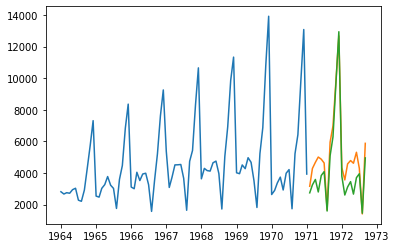

In [16]:
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Prediction")
plt.show()

In [17]:
from sklearn.metrics import r2_score
test["predict"]=prediction
r2_score(test["Champagne sales"],test["predict"])

<ipython-input-17-12ae65ef1aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predict"]=prediction


0.8114858899205082